In [1]:
import torch
import pytorch_lightning as pytorch_lightning
import sys

sys.path.append('../lhdm')
sys.path.append('../lhdm/data')

from irn_dataset import DataHandler
%load_ext autoreload
%autoreload 2

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hparams = {
    "split_ratio": [80, 10, 10],
    "device": device,
    "batch_size": 8,
    "num_workers": 4,
    "sample_limit": 1,
    "input_dim": 1185,
    "output_dim": 1185,
    "hidden_dim": 512,
    "z_dim": 64
}
datahandler = DataHandler(hparams, "lhdm/data/mnist-inrs", "mnist_png_training_9")

train_loader = datahandler.train_dataloader()
val_loader = datahandler.val_dataloader()
next(iter(train_loader))

[W1120 16:16:54.545738934 CudaIPCTypes.cpp:16] Producer process has been terminated before all shared CUDA tensors released. See Note [Sharing CUDA tensors]


tensor([[ 0.0244,  0.0118,  0.0276,  ..., -0.0918, -0.1661, -0.1385]],
       device='cuda:0')

In [ ]:
import sys
sys.path.append('../lhdm/models')

from inr import INR
state_dict = datahandler.get_state_dict(index=0)

params = {
    "input_size": 2,
    "hidden_size": 32,
    "output_size": 1
}

#mlp = MLP(params)
mlp = INR(up_scale=16)
print(mlp)
mlp.load_state_dict(state_dict)
test_input = torch.randn(2)
print(test_input)
print(mlp(test_input))


INR(
  (seq): Sequential(
    (0): Siren(
      (activation): Sine()
    )
    (1): Siren(
      (activation): Sine()
    )
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)
tensor([0.5418, 0.3348])
tensor([0.0133], grad_fn=<AddBackward0>)


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image(mlp_model):
    # Generate a 28x28 grid of (x, y) inputs
    resolution = 28
    x = np.linspace(-1, 1, resolution)  # Normalize to range [-1, 1]
    y = np.linspace(-1, 1, resolution)
    grid_x, grid_y = np.meshgrid(x, y)

    # Flatten the grid into a list of (x, y) pairs
    inputs = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)
    #print(inputs)
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)

    # Pass the inputs through the MLP
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = mlp_model(inputs_tensor).numpy()

    # Reshape the outputs into a 28x28 image
    image = outputs.reshape(resolution, resolution)

    # Plot the image
    plt.imshow(image, cmap="gray", extent=(-1, 1, -1, 1))
    plt.colorbar(label="Grayscale Value")
    plt.title("Generated Grayscale Image")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [15]:
import pytorch_lightning as pl
import torch
from pytorch_lightning.loggers import WandbLogger
from models import Autoencoder

wandb_logger = WandbLogger(log_model="all")
trainer = pl.Trainer(logger=wandb_logger, max_epochs=10)

model = Autoencoder(ddconfig=hparams, embed_dim=16)

# trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


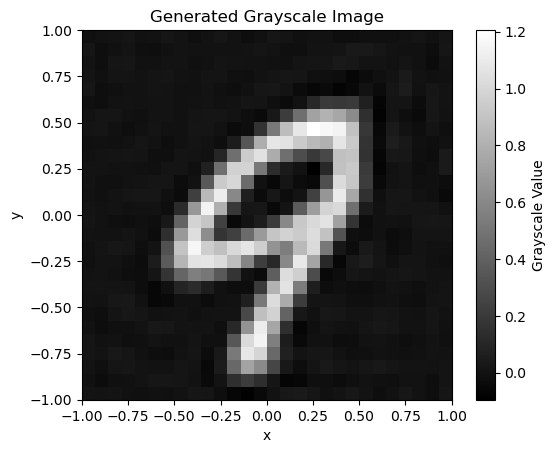

In [16]:
# weights = model(next(iter(train_loader))).flatten()

# mlp_reconstructed = INR(up_scale=16)
# state_dict = mlp_reconstructed.state_dict()
# it = 0
# for k,v in state_dict.items():
#     num_param = v.numel()

#     values = weights[it:it+num_param]

#     reshaped_values = values.view_as(v)

#     state_dict[k] = reshaped_values

#     it += num_param
# mlp_reconstructed.load_state_dict(state_dict)
plot_image(mlp)
# plot_image(mlp_reconstructed)